In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("CAX_LogFacies_Train_File.csv" )
#test=pd.read_csv("CAX_LogFacies_Test_File.csv")

## Distribucion de clases por pozo. Vemos que la clase mayoritaria es un 50% en casi todos los pozos y la distribucion de las demas es casi la misma

In [ ]:
def huberlambda(x,y):
    X = np.array(range(x)).reshape(-1,1)
    huber = HuberRegressor().fit(X, y)
    return huber
df['GR_mnorm'] = df.groupby('well_id')['GR'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df["1huber"] = df.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: huberlambda(20, y).coef_,'raw=False').reset_index(0,drop=True)
df["2huber"] = df.groupby('well_id')['GR_mnorm'].rolling(40,center=True).apply(lambda y: huberlambda(40, y).coef_,'raw=False').reset_index(0,drop=True)
df["0polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: np.polyfit(np.array(range(20)), y, 2)[0],'raw=False').reset_index(0,drop=True)
df["1polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(30,center=True).apply(lambda y: np.polyfit(np.array(range(30)), y, 2)[1],'raw=False').reset_index(0,drop=True)
df["2polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(50,center=True).apply(lambda y: np.polyfit(np.array(range(50)), y, 2)[2],'raw=False').reset_index(0,drop=True)

# df['20rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(20,win_type = "barthann",min_periods=1,center= True).mean().reset_index(0,drop=True)
df['30rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)
# df['40rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)



df['30rolling_std'] = df.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
# df['40rolling_std'] = df.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
df=df.fillna(0)

In [ ]:
def transform_shfit(df,k,GR):
    for i in range(1,k):
        a = i*2
        df["- "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(a))
        df["+ "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(-a))
    df=df.fillna(0)
    return df

df=transform_shfit(df,10,"40rolling_mean")
df=transform_shfit(df,10,"1huber")
df=transform_shfit(df,10,"GR_mnorm")
df=train.fillna(0)


## Se agrego el valor de los siguientes 10 valores para atras y para adelante de cada punto para las ventanas de medias y ventana de variacion

## Division 40 pozos enteros para train y 10 pozos para test.

In [ ]:
test_series = pd.DataFrame(df["well_id"].unique().tolist(), columns = ["well_id"]).sample(frac = 0.3, random_state = 0)
train = df[(~df["well_id"].isin(test_series["well_id"]))]
test = df[(df["well_id"].isin(test_series["well_id"]))]
y_train = train["label"]
y_test = test["label"]
x_train = train.drop(["label","name"],axis=1,errors = 'ignore' )
x_test = test.drop(["label","name"],axis=1,errors = 'ignore' )

# y=df["label"]
# x=df.drop(["label","name"],axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle = False )

## Planteo de modelo geneerico de random forest. Falta optimizar hiperparametros mediante crossvalidation o similar

In [ ]:
best_pparams = {'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 156,
 'max_features': 0.4,
 'n_estimators': 288}

In [ ]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=100, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=2, min_samples_split=10,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

model = RandomForestClassifier(**best_params)
model.fit(x_train, y_train)

## Score evaluado sobre el mismo training 0.990341

In [ ]:
predictions = model.predict(x_test)
model.score(x_train, y_train)

In [ ]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
model.score(x_test, y_test)

In [85]:
test = x_test.copy()
test["predictions"] = predictions
test.loc[test["predictions"]== 1, "predictions"] = 1
test["label"] = y_test
test.loc[test["predictions"]>=0,"predictionsuni"] = 1.2
test.loc[test["label"]>=0,"labeluni"] = 1

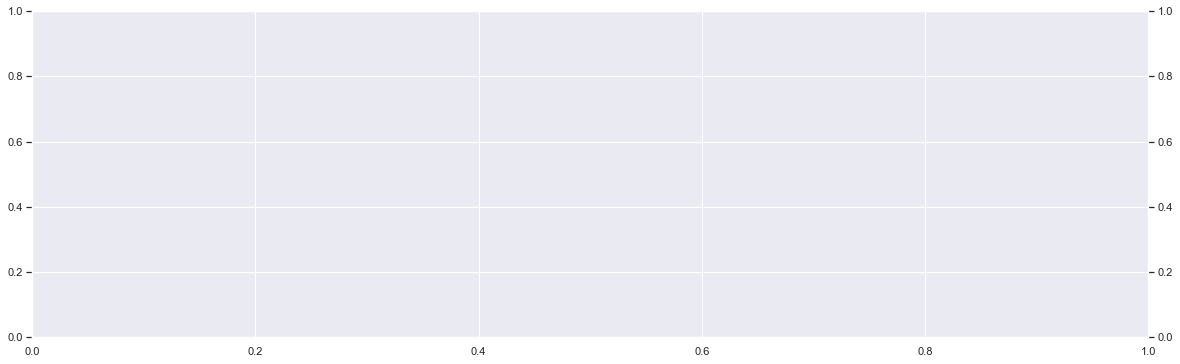

In [86]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i))
    labels= df["label"].unique()
    pastel = sns.color_palette('pastel',5)
    dark = sns.color_palette('dark', 5)

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copydf = df.copy()
        copydf.loc[copydf['label']!= l, ["GR","labeluni","predictionsuni"]] = np.nan
        axes1.plot(copydf["GR"], color=pastel[l])
        axes2.plot(copydf["predictionsuni"], color=pastel[l],linewidth=10.0)
        axes2.plot(copydf["labeluni"], color=dark[l],linewidth=10.0)
plot_multicolored_line(test ,2543)


In [87]:
confus = confusion_matrix(y_test, predictions)
print(confus)
print(classification_report(y_test,predictions))

[[9518   55    0   78   89]
 [ 238 1793  245  184  149]
 [   2  193 2397   22   32]
 [ 423  179  123 1910   66]
 [ 310  106   67   59 1892]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9740
           1       0.77      0.69      0.73      2609
           2       0.85      0.91      0.88      2646
           3       0.85      0.71      0.77      2701
           4       0.85      0.78      0.81      2434

    accuracy                           0.87     20130
   macro avg       0.84      0.81      0.83     20130
weighted avg       0.87      0.87      0.87     20130



In [88]:
print(pd.DataFrame(confus).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     0 &     1 &     2 &     3 &     4 \\
\midrule
0 &  9518 &    55 &     0 &    78 &    89 \\
1 &   238 &  1793 &   245 &   184 &   149 \\
2 &     2 &   193 &  2397 &    22 &    32 \\
3 &   423 &   179 &   123 &  1910 &    66 \\
4 &   310 &   106 &    67 &    59 &  1892 \\
\bottomrule
\end{tabular}



In [89]:
dfclass = pd.DataFrame(classification_report(y_test,predictions,output_dict=True)).transpose().round(3)
dfclass

,precision,recall,f1-score,support
0,0.907,0.977,0.941,9740.00
1,0.771,0.687,0.727,2609.00
2,0.846,0.906,0.875,2646.00
3,0.848,0.707,0.771,2701.00
4,0.849,0.777,0.812,2434.00
accuracy,0.870,0.870,0.870,0.87
macro avg,0.844,0.811,0.825,20130.00
weighted avg,0.867,0.870,0.866,20130.00


## Score evaluado sobre los 10 pozos de testing. 0.87

## Importancia de las variables junto con su variacion en el random forest:

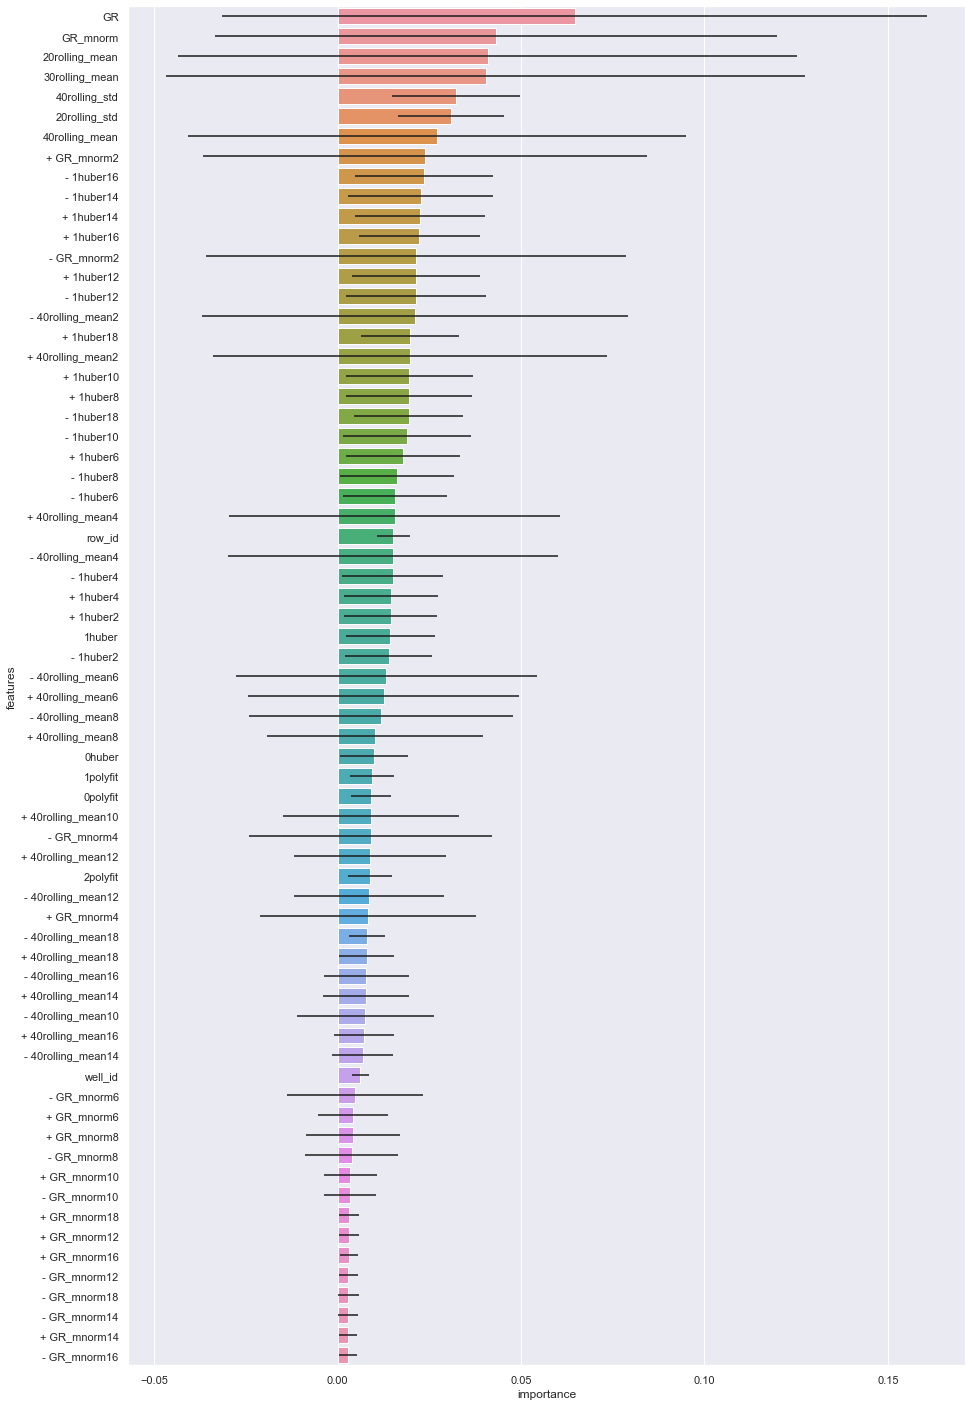

In [75]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,25)})
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
importance = model.feature_importances_
features = x_train.columns

feature_importance = pd.DataFrame()
feature_importance["importance"] = importance
feature_importance["std"] = std
feature_importance["features"] = features
feature_importance.sort_values("importance",ascending=False, inplace=True)
feature_importance.reset_index(drop = True , inplace = True)
sns.barplot(data =feature_importance , x ="importance", y ="features",xerr=feature_importance["std"])

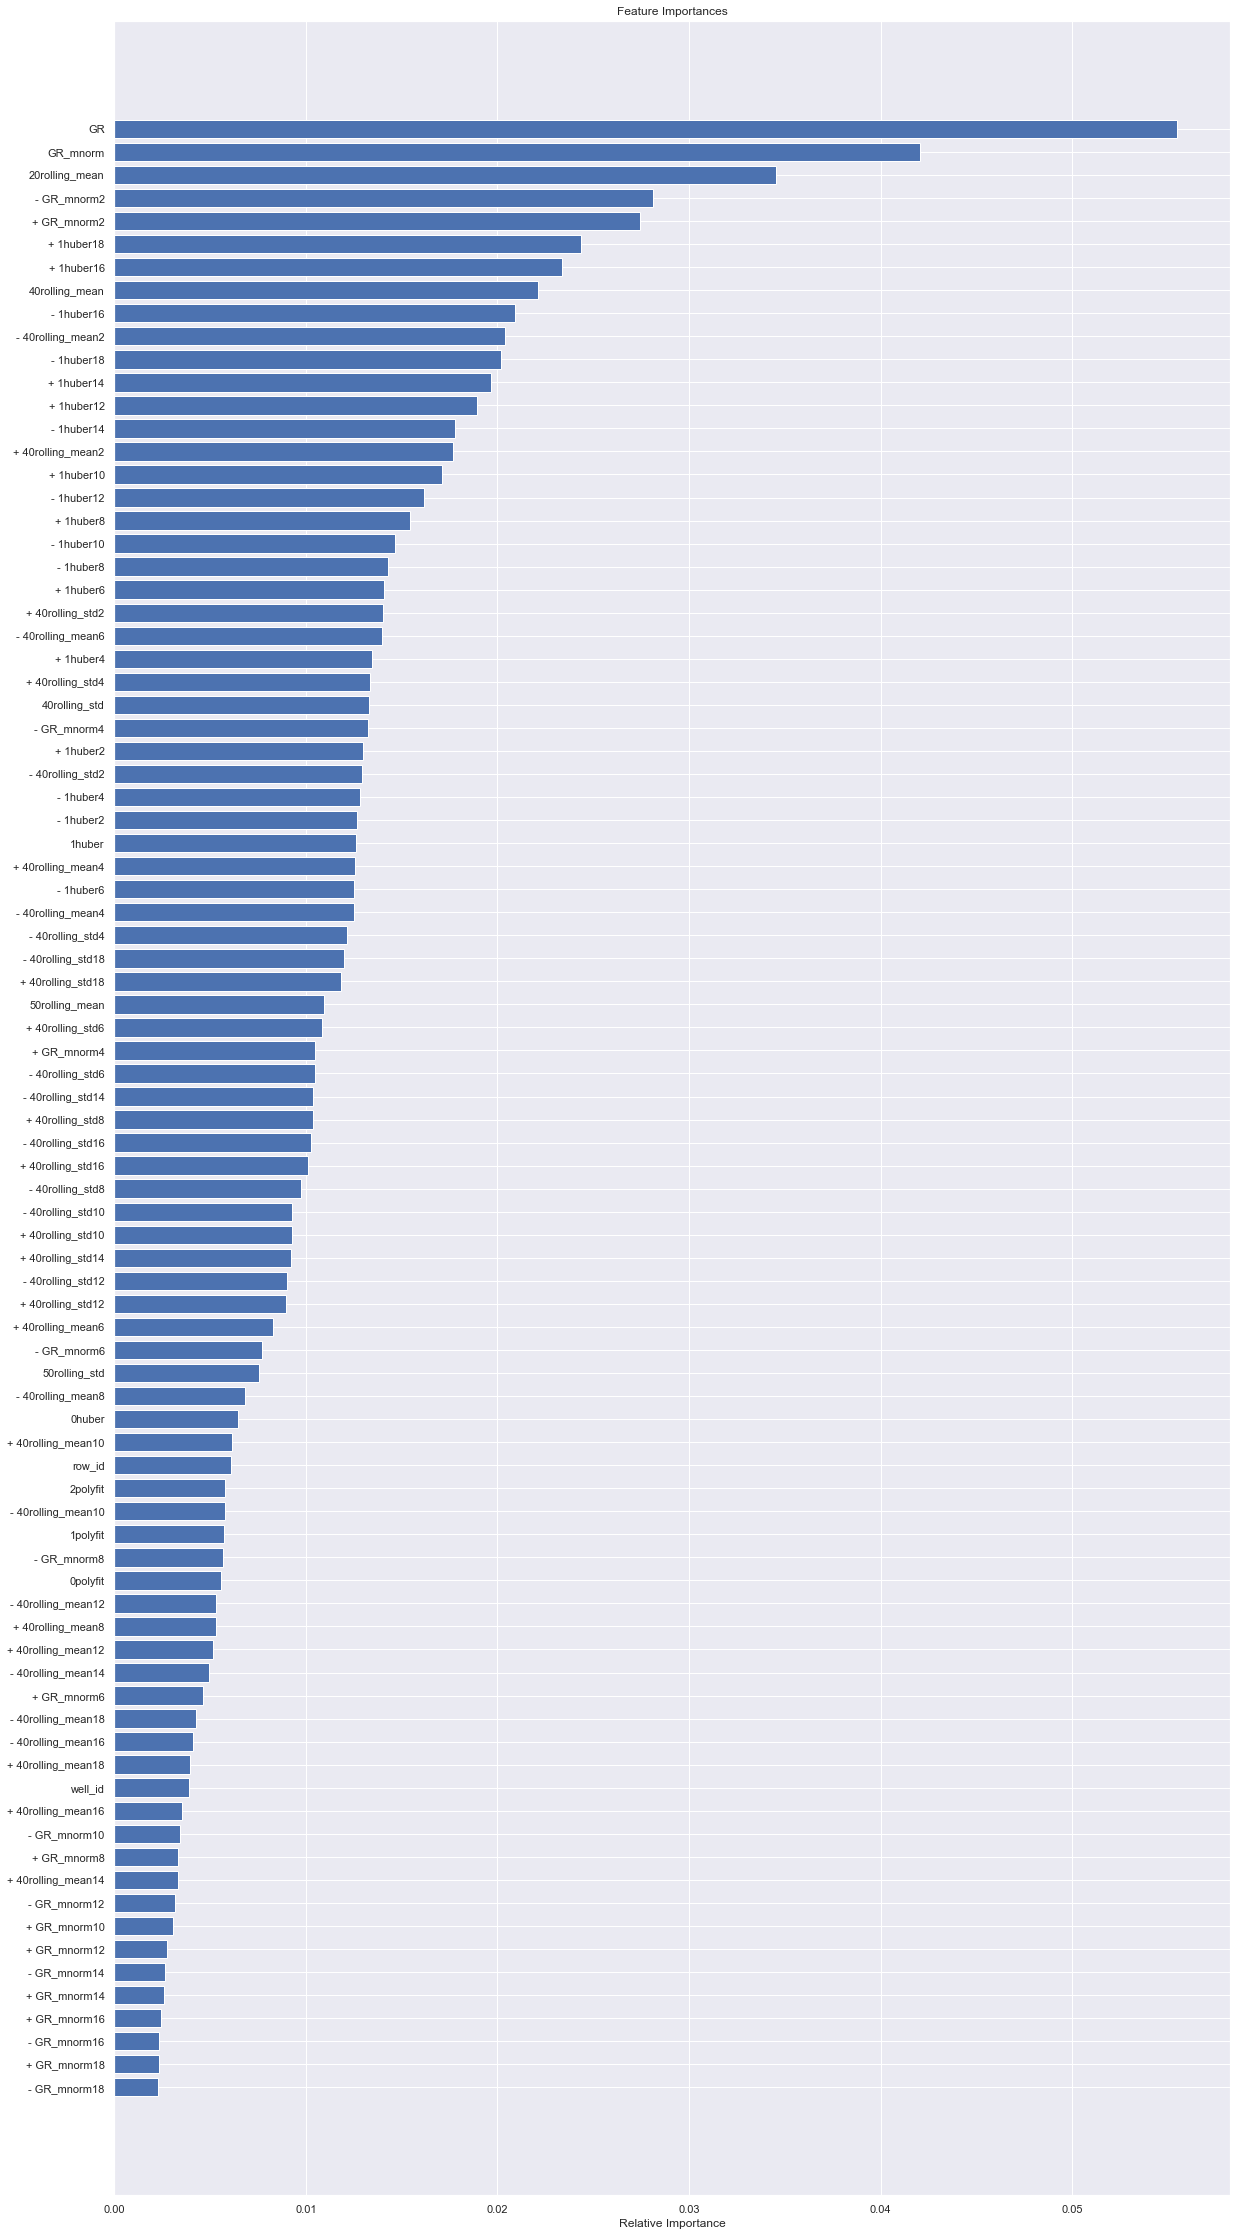

In [18]:
features = x_test.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
plt.title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Planteo de Random foresto optimizacion no utilizado

Feature ranking:


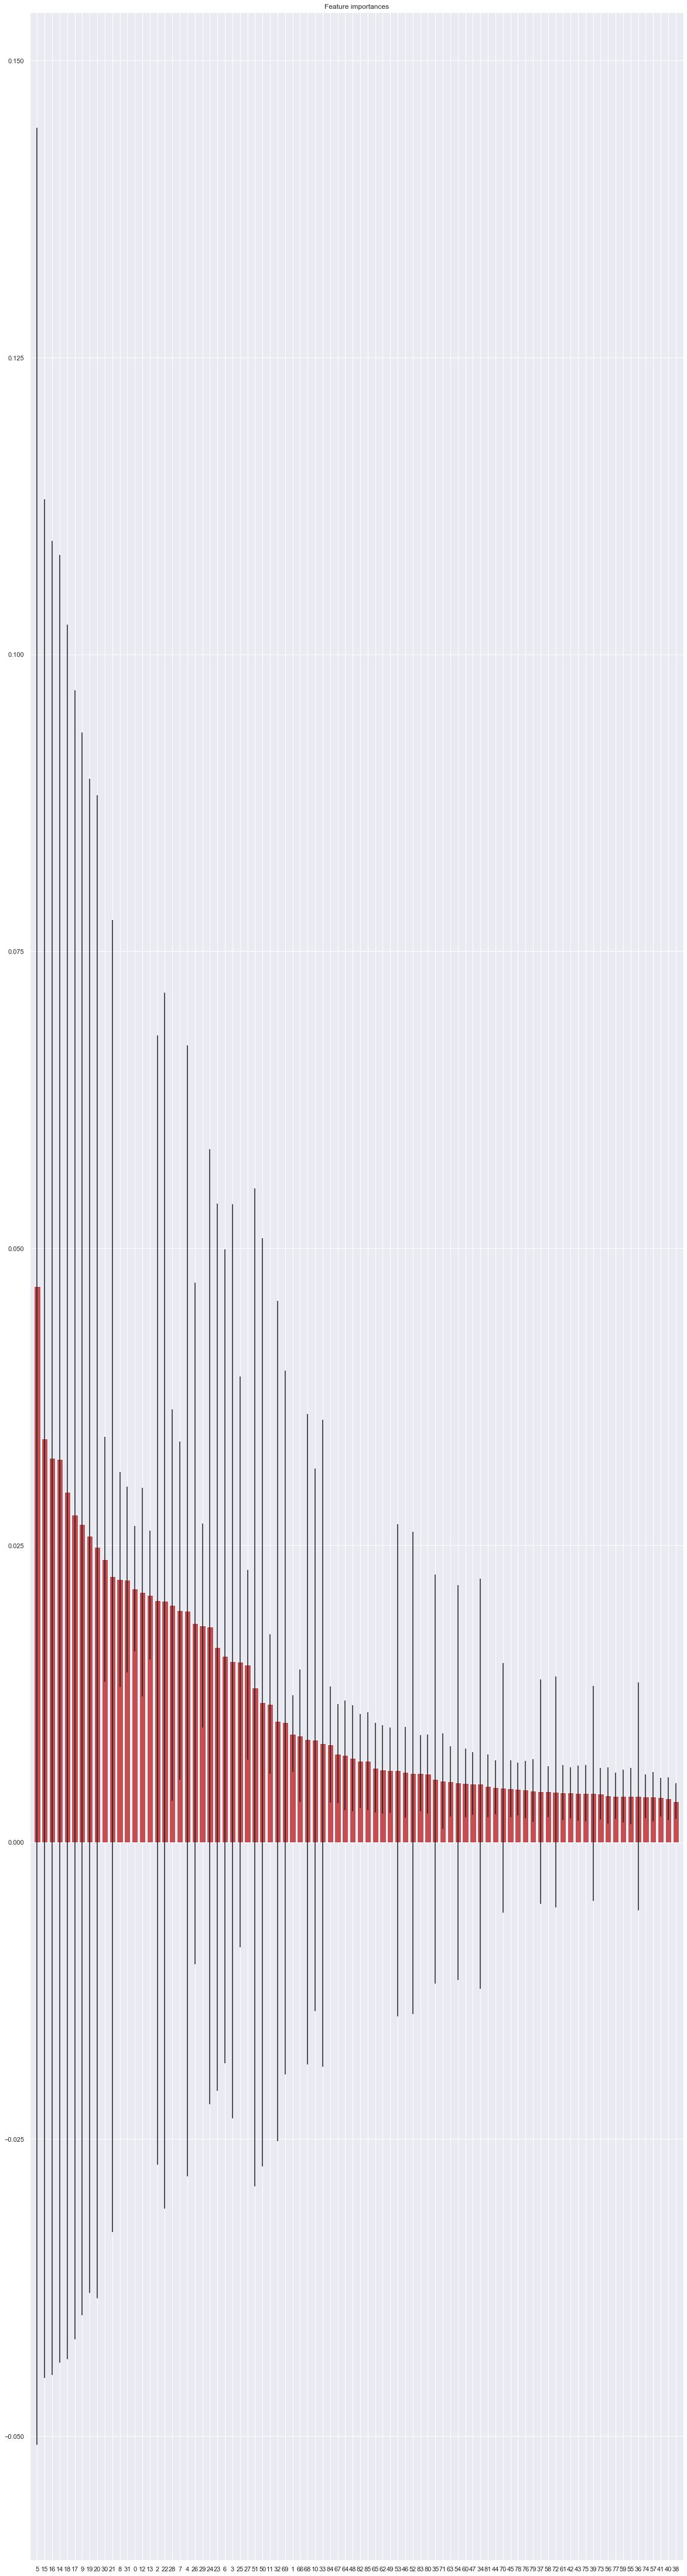

In [23]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [16]:
'''rf = RandomForestClassifier()
gs = GridSearchCV(rf,{ 'max_depth': np.arange(20,51,5),
                    'n_estimators':np.arange(400,1500,150),
                    'max_features':np.arange(0.39,0.91,0.05)}
                      ,verbose=2,n_jobs=-1, 
                        error_score='raise')

gs.fit(x_train,y_train.values.ravel())
gs.best_score_, gs.best_params_'''
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [17]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=644,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)